# Empirical Pareto Analysis

This section integrates all consensus dimensions—Safety, Efficiency, and Interaction—into a unified Pareto framework. We normalized capped metrics, derived composite scores, and identified non-dominated points representing optimal trade-offs among objectives. Visualizations include neutral scoring with hollow markers, triangulated Pareto surfaces, and directional radial meshes to capture empirical front structure across datasets.


## Neutral Scoring and Hollow Markers

We implemented a neutral-scoring Pareto framework that retains the same visualization layout as before but introduces per-context normalization and improved handling of degenerate cases. Metrics exceeding eligibility caps (e.g., TTC>10 s, PET>7 s) were marked as missing. If both terms in an objective were missing, a neutral score of 0.5 was assigned. Hollow markers highlight events involving such neutral scores. The resulting visualization preserves policy checks in raw space while differentiating fully observed from partially inferred composites.

Total events: 261
Pareto: 23 (8.8%)
Pareto & compliant: 16 (6.1%)
context
Foggy Bottom    142
I-395           119
Name: count, dtype: int64
Wrote: Pareto_Events_with_Composites.csv


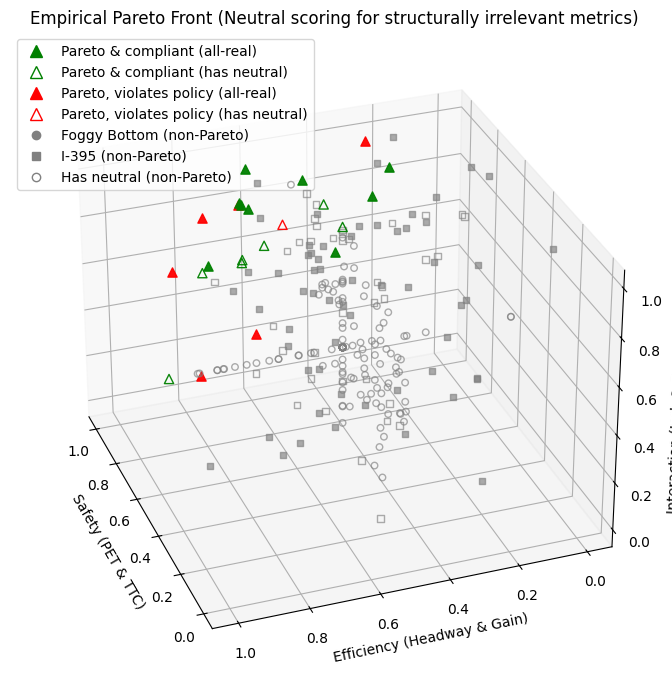

In [2]:
# ===== Empirical Pareto with Neutral Scoring & Hollow Markers (updated points per Code 2) =====
# - Same figure/legend/markers as Code 1
# - Points now computed with Code 2 fixes:
#     * Caps: TTC>10, PET>7, Headway>10 (and ±∞) -> NaN
#     * Per-context normalization with degenerate-range fix (single value -> 1.0)
#     * Composite = mean of available terms; if both missing -> 0.5 (neutral)
#     * has_neutral = True only if any composite used 0.5
#     * Policy checks in RAW space; NaN ignored

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

CSV_PATH = "Merged_AV_Consensus_FB_I395.csv"  # change if needed

# --- policy thresholds (RAW space) ---
THRESH = {
    "TTC_min": 3.0,
    "PET_min": 2.25,
    "Headway_max": 4.0,
    "Gain_max": 1.0,
    "Jerk_max": 2.5,
    "Decel_max": 2.0,
}

# --- load ---
dfm = pd.read_csv(CSV_PATH)

# *_x came from Foggy Bottom (intersections); *_y came from I-395 (10 s windows)
X_cols = ['TTC_x','PET_x','Decel_x','Jerk_x','Headway_x','Gain_x']
Y_cols = ['TTC_y','PET_y','Decel_y','Jerk_y','Headway_y','Gain_y']

def infer_context(row):
    x_count = row[X_cols].notna().sum()
    y_count = row[Y_cols].notna().sum()
    if x_count > 0 and y_count == 0: return "Foggy Bottom"
    if y_count > 0 and x_count == 0: return "I-395"
    if x_count > 0 and y_count > 0:  return "BOTH"
    return "NONE"

dfm["context"] = dfm.apply(infer_context, axis=1)
dfm = dfm[dfm["context"].isin(["Foggy Bottom","I-395","BOTH"])].copy()

# --- collapse *_x/*_y to unified columns (prefer whichever side is present) ---
def coalesce(row, a, b):
    return row[a] if pd.notna(row[a]) else row[b]

for base in ["TTC","PET","Decel","Jerk","Headway","Gain"]:
    dfm[base] = dfm.apply(lambda r: coalesce(r, f"{base}_x", f"{base}_y"), axis=1)

# --- caps & clean (mark ineligible as NaN) ---
import numpy as np
def cap_to_nan(series, cap):
    s = pd.to_numeric(series, errors="coerce").replace([np.inf, -np.inf], np.nan)
    s.loc[s > cap] = np.nan
    return s

dfm["TTC"]     = cap_to_nan(dfm["TTC"], 10.0)      # >10s ineligible
dfm["PET"]     = cap_to_nan(dfm["PET"], 7.0)       # >7s ineligible
dfm["Headway"] = cap_to_nan(dfm["Headway"], 10.0)  # >10s ineligible
# Gain, Jerk, Decel: keep numeric, coerce ±∞ to NaN
for base in ["Gain","Jerk","Decel"]:
    dfm[base] = pd.to_numeric(dfm[base], errors="coerce").replace([np.inf, -np.inf], np.nan)

# --- normalization helpers (per Code 2 behavior) ---
def normalize_up(series: pd.Series) -> pd.Series:
    """Higher is better; min-max on finite. If exactly one finite value, map it to 1.0."""
    s = pd.to_numeric(series, errors='coerce').replace([np.inf, -np.inf], np.nan)
    finite = s.dropna()
    out = pd.Series(np.nan, index=s.index)
    if finite.empty:
        return out
    lo, hi = finite.min(), finite.max()
    if hi == lo:
        out.loc[finite.index] = 1.0
    else:
        out.loc[finite.index] = (finite - lo) / (hi - lo)
    return out

def normalize_down(series: pd.Series) -> pd.Series:
    """Lower is better; min-max then invert to [0,1]. If exactly one finite value, map it to 1.0."""
    s = pd.to_numeric(series, errors='coerce').replace([np.inf, -np.inf], np.nan)
    finite = s.dropna()
    out = pd.Series(np.nan, index=s.index)
    if finite.empty:
        return out
    lo, hi = finite.min(), finite.max()
    if hi == lo:
        out.loc[finite.index] = 1.0
    else:
        base = (finite - lo) / (hi - lo)
        out.loc[finite.index] = 1.0 - base
    return out

def smart_mean_2(a: pd.Series, b: pd.Series) -> pd.Series:
    """Mean over present terms in a 2-term objective.
       If both NaN -> 0.5; if one valid -> use that value."""
    out = []
    for x, y in zip(a, b):
        vals = []
        if pd.notna(x): vals.append(x)
        if pd.notna(y): vals.append(y)
        if len(vals) == 0:
            out.append(0.5)
        elif len(vals) == 1:
            out.append(vals[0])
        else:
            out.append(float(np.mean(vals)))
    return pd.Series(out, index=a.index)

def meets(val, op, thr):
    """Threshold check in RAW space; NaN = ignored (does not help or hurt)."""
    if pd.isna(val):
        return True
    if op == ">":  return val > thr
    if op == "<":  return val < thr
    if op == "<=": return val <= thr
    if op == ">=": return val >= thr
    raise ValueError("op")

# --- build objectives per context (so ranges are comparable within regime) ---
parts = []
for ctx, g in dfm.groupby("context"):
    g = g.copy()

    # normalized terms (after caps)
    PET_n   = normalize_up(g["PET"])        # ↑ good
    TTC_n   = normalize_up(g["TTC"])        # ↑ good
    HW_inv  = normalize_down(g["Headway"])  # ↓ good
    G_inv   = normalize_down(g["Gain"])     # ↓ good
    JRK_inv = normalize_down(g["Jerk"])     # ↓ good
    DEC_inv = normalize_down(g["Decel"])    # ↓ good

    # composites using only available terms; both missing -> 0.5
    Safety      = smart_mean_2(PET_n, TTC_n)
    Efficiency  = smart_mean_2(HW_inv, G_inv)
    Interaction = smart_mean_2(JRK_inv, DEC_inv)

    # has_neutral = True only if a composite used the 0.5 fallback (both terms missing)
    term_df = pd.DataFrame({
        "s1": PET_n, "s2": TTC_n,
        "e1": HW_inv, "e2": G_inv,
        "i1": JRK_inv, "i2": DEC_inv
    }, index=g.index)
    has_neutral = (
        term_df[["s1","s2"]].isna().all(axis=1) |
        term_df[["e1","e2"]].isna().all(axis=1) |
        term_df[["i1","i2"]].isna().all(axis=1)
    )

    out = g.copy()
    out["Safety"] = Safety
    out["Efficiency"] = Efficiency
    out["Interaction"] = Interaction
    out["has_neutral"] = has_neutral

    # policy compliance in RAW space (NaN ignored)
    out["pass_safety"] = (
        out["TTC"].apply(lambda v: meets(v, ">", THRESH["TTC_min"])) &
        out["PET"].apply(lambda v: meets(v, ">", THRESH["PET_min"]))
    )
    out["pass_eff"] = (
        out["Headway"].apply(lambda v: meets(v, "<=", THRESH["Headway_max"])) &
        out["Gain"].apply(lambda v: meets(v, "<=", THRESH["Gain_max"]))
    )
    out["pass_int"] = (
        out["Jerk"].apply(lambda v: meets(v, "<", THRESH["Jerk_max"])) &
        out["Decel"].apply(lambda v: meets(v, "<", THRESH["Decel_max"]))
    )
    out["pass_all"] = out[["pass_safety","pass_eff","pass_int"]].all(axis=1)

    parts.append(out)

df = pd.concat(parts, ignore_index=True)

# --- Pareto tagging (overall) ---
def non_dominated_mask(X: np.ndarray) -> np.ndarray:
    n = X.shape[0]
    dominated = np.zeros(n, dtype=bool)
    for i in range(n):
        if dominated[i]:
            continue
        ge_all = (X >= X[i]).all(axis=1)      # ≥ in all
        gt_any = (X >  X[i]).any(axis=1)      # > in at least one
        dom_i = ge_all & gt_any
        dom_i[i] = False
        if dom_i.any():
            dominated[i] = True
    return ~dominated

X = df[["Safety","Efficiency","Interaction"]].to_numpy(float)
df["pareto"] = non_dominated_mask(X)

# --- quick counts ---
tot = len(df)
n_front = int(df["pareto"].sum())
n_front_compliant = int((df["pareto"] & df["pass_all"]).sum())
print(f"Total events: {tot}")
print(f"Pareto: {n_front} ({n_front/tot:.1%})")
print(f"Pareto & compliant: {n_front_compliant} ({n_front_compliant/tot:.1%})")
print(df["context"].value_counts())

# --- save the Pareto table for inspection (same filename as Code 1 for continuity) ---
cols_out = ["context","event_id","av_id",
            "Safety","Efficiency","Interaction","pareto","pass_all","has_neutral",
            "TTC","PET","Headway","Gain","Jerk","Decel"]
cols_existing = [c for c in cols_out if c in df.columns]
df[cols_existing].to_csv("Pareto_Events_with_Composites.csv", index=False)
print("Wrote: Pareto_Events_with_Composites.csv")

# --- plotting (same visual rules as Code 1) ---
def base_color(row):
    if row["pareto"]:
        return "green" if row["pass_all"] else "red"
    return "gray"

def base_marker(row):
    if row["pareto"]:
        return "^"          # triangle
    return "o" if row["context"]=="Foggy Bottom" else "s"  # circle vs square

fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111, projection='3d')

for _, r in df.iterrows():
    kw = dict(s=44 if r["pareto"] else 22,
              marker=base_marker(r),
              alpha=0.95 if r["pareto"] else 0.65)
    if r["has_neutral"]:
        ax.scatter(r["Safety"], r["Efficiency"], r["Interaction"],
                   edgecolors=base_color(r), facecolors='none', **kw)  # hollow
    else:
        ax.scatter(r["Safety"], r["Efficiency"], r["Interaction"],
                   c=base_color(r), **kw)  # solid

ax.set_xlabel("Safety (PET & TTC)")
ax.set_ylabel("Efficiency (Headway & Gain)")
ax.set_zlabel("Interaction (Jerk & Decel)")
ax.set_title("Empirical Pareto Front (Neutral scoring for structurally irrelevant metrics)")

# Legend proxies (unchanged)
import matplotlib.lines as mlines
solid_tri_green = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=8, label='Pareto & compliant (all-real)')
hollow_tri_green = mlines.Line2D([], [], color='green', marker='^', linestyle='None', markersize=8, markerfacecolor='none', label='Pareto & compliant (has neutral)')
solid_tri_red = mlines.Line2D([], [], color='red', marker='^', linestyle='None', markersize=8, label='Pareto, violates policy (all-real)')
hollow_tri_red = mlines.Line2D([], [], color='red', marker='^', linestyle='None', markersize=8, markerfacecolor='none', label='Pareto, violates policy (has neutral)')
solid_fb = mlines.Line2D([], [], color='gray', marker='o', linestyle='None', markersize=6, label='Foggy Bottom (non-Pareto)')
solid_i395 = mlines.Line2D([], [], color='gray', marker='s', linestyle='None', markersize=6, label='I-395 (non-Pareto)')
hollow_generic = mlines.Line2D([], [], color='gray', marker='o', linestyle='None', markersize=6, markerfacecolor='none', label='Has neutral (non-Pareto)')

ax.legend(handles=[solid_tri_green, hollow_tri_green, solid_tri_red, hollow_tri_red, solid_fb, solid_i395, hollow_generic],
          loc='upper left')

ax.view_init(elev=30, azim=160)
plt.tight_layout()
plt.show()


## Triangulated Pareto Surface

We extended the analysis by constructing a convex-hull-based Pareto surface from all non-dominated points. Each face of the hull represents a locally optimal balance among safety, efficiency, and interaction. Facets oriented toward the positive axes were retained to approximate the empirical upper envelope. This visualization allows direct comparison between Foggy Bottom and I-395 events while illustrating the frontier’s continuity and structure.

In [5]:
# ===== Empirical Pareto Surface (triangulated) =====
# Caps & ineligibility:
#   - TTC > 10 s or ±∞ -> NaN (ineligible)
#   - PET > 7 s or ±∞  -> NaN (ineligible)
#   - Headway > 10 s or ±∞ -> NaN (ineligible)
#
# Objectives & direction:
#   - Safety      = PET (↑), TTC (↑)
#   - Efficiency  = Headway (↓), Gain (↓)
#   - Interaction = Jerk (↓), Decel (↓)
#
# Composite rule:
#   - Use ONLY available terms; if both missing ⇒ neutral 0.5.
#
# Normalization:
#   - Min–max on finite values per-context.
#   - If a metric has exactly one finite value (hi == lo), map that value to 1.0.
#
# Policy checks:
#   - Done in RAW space; NaN ignored (does not auto-pass or auto-fail).
#
# Pareto:
#   - Non-dominated sorting on (Safety, Efficiency, Interaction), all maximized.
#   - Triangulated “upper envelope” via ConvexHull facets (kept by normal heuristic).
#
# Outputs:
#   - Pareto_Points_Table.csv
#   - pareto_tri_view1..4.png, pareto_surface_mesh.png
#   - pareto_tri_spin.gif (optional, if imageio installed)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# ---------- CONFIG ----------
CSV_PATH = "Merged_AV_Consensus_FB_I395.csv"  # change if needed

THRESH = {
    "TTC_min": 3.0,
    "PET_min": 2.25,
    "Headway_max": 4.0,
    "Gain_max": 1.0,
    "Jerk_max": 2.5,
    "Decel_max": 2.0,
}

# ---------- LOAD & UNIFY ----------
dfm = pd.read_csv(CSV_PATH)

# In your merge: *_x = Foggy Bottom, *_y = I-395
X_cols = ['TTC_x','PET_x','Decel_x','Jerk_x','Headway_x','Gain_x']
Y_cols = ['TTC_y','PET_y','Decel_y','Jerk_y','Headway_y','Gain_y']

def infer_context(row):
    x_count = row[X_cols].notna().sum()
    y_count = row[Y_cols].notna().sum()
    if x_count > 0 and y_count == 0: return "Foggy Bottom"
    if y_count > 0 and x_count == 0: return "I-395"
    if x_count > 0 and y_count > 0:  return "BOTH"  # rare in this outer merge
    return "NONE"

dfm["context"] = dfm.apply(infer_context, axis=1)
dfm = dfm[dfm["context"].isin(["Foggy Bottom","I-395","BOTH"])].copy()

def coalesce(row, a, b):
    return row[a] if pd.notna(row[a]) else row[b]

for base in ["TTC","PET","Decel","Jerk","Headway","Gain"]:
    dfm[base] = dfm.apply(lambda r: coalesce(r, f"{base}_x", f"{base}_y"), axis=1)

# ---------- CAPS (mark ineligible as NaN) ----------
def cap_to_nan(series, cap):
    s = pd.to_numeric(series, errors="coerce").replace([np.inf, -np.inf], np.nan)
    s.loc[s > cap] = np.nan
    return s

dfm["TTC"]     = cap_to_nan(dfm["TTC"], 10.0)      # >10s ineligible
dfm["PET"]     = cap_to_nan(dfm["PET"], 7.0)       # >7s ineligible
dfm["Headway"] = cap_to_nan(dfm["Headway"], 10.0)  # >10s ineligible

# ---------- NORMALIZATION HELPERS (with degenerate-range fix) ----------
def normalize_up(series: pd.Series) -> pd.Series:
    """
    Higher-is-better. Min–max on finite values only.
    If only one finite value exists (hi==lo), map that value to 1.0.
    """
    s = pd.to_numeric(series, errors='coerce').replace([np.inf, -np.inf], np.nan)
    finite = s.dropna()
    out = pd.Series(np.nan, index=s.index)
    if finite.empty:
        return out
    lo, hi = finite.min(), finite.max()
    if hi == lo:
        out.loc[finite.index] = 1.0
    else:
        out.loc[finite.index] = (finite - lo) / (hi - lo)
    return out

def normalize_down(series: pd.Series) -> pd.Series:
    """
    Lower-is-better. Min–max then invert to [0,1].
    If only one finite value exists (hi==lo), map that value to 1.0.
    """
    s = pd.to_numeric(series, errors='coerce').replace([np.inf, -np.inf], np.nan)
    finite = s.dropna()
    out = pd.Series(np.nan, index=s.index)
    if finite.empty:
        return out
    lo, hi = finite.min(), finite.max()
    if hi == lo:
        out.loc[finite.index] = 1.0
    else:
        base = (finite - lo) / (hi - lo)
        out.loc[finite.index] = 1.0 - base
    return out

def meets(val, op, thr):
    """Threshold check in RAW space; NaN = ignored (neither helps nor hurts)."""
    if pd.isna(val):
        return True
    if op == ">":  return val > thr
    if op == "<":  return val < thr
    if op == "<=": return val <= thr
    if op == ">=": return val >= thr
    raise ValueError("Unknown op")

def smart_mean_2(a: pd.Series, b: pd.Series) -> pd.Series:
    """
    Mean over present terms in a 2-term objective.
    If both NaN → 0.5 neutral; if one valid → that value alone.
    """
    out = []
    for x, y in zip(a, b):
        xs = []
        if pd.notna(x): xs.append(x)
        if pd.notna(y): xs.append(y)
        if len(xs) == 0:
            out.append(0.5)
        elif len(xs) == 1:
            out.append(xs[0])
        else:
            out.append(float(np.mean(xs)))
    return pd.Series(out, index=a.index)

# ---------- COMPOSITES ----------
frames = []
for ctx, g in dfm.groupby("context"):
    g = g.copy()

    PET_n   = normalize_up(g["PET"])        # ↑ good; PET>7 set to NaN
    TTC_n   = normalize_up(g["TTC"])        # ↑ good; TTC>10 set to NaN
    HW_inv  = normalize_down(g["Headway"])  # ↓ good; Headway>10 set to NaN
    G_inv   = normalize_down(g["Gain"])     # ↓ good
    JRK_inv = normalize_down(g["Jerk"])     # ↓ good
    DEC_inv = normalize_down(g["Decel"])    # ↓ good

    # Objective scores: use available terms; if both missing -> 0.5
    g["Safety"]      = smart_mean_2(PET_n, TTC_n)
    g["Efficiency"]  = smart_mean_2(HW_inv, G_inv)
    g["Interaction"] = smart_mean_2(JRK_inv, DEC_inv)

    # Flag if any objective needed neutral fill (both terms missing)
    term_df = pd.DataFrame({
        "s1": PET_n, "s2": TTC_n,
        "e1": HW_inv, "e2": G_inv,
        "i1": JRK_inv, "i2": DEC_inv
    }, index=g.index)
    g["has_neutral"] = term_df[["s1","s2"]].isna().all(axis=1) | \
                       term_df[["e1","e2"]].isna().all(axis=1) | \
                       term_df[["i1","i2"]].isna().all(axis=1)

    # Compliance in RAW space (NaN ignored)
    g["pass_safety"] = (g["TTC"].apply(lambda v: meets(v, ">", THRESH["TTC_min"])) &
                        g["PET"].apply(lambda v: meets(v, ">", THRESH["PET_min"])))
    g["pass_eff"]    = (g["Headway"].apply(lambda v: meets(v, "<=", THRESH["Headway_max"])) &
                        g["Gain"].apply(lambda v: meets(v, "<=", THRESH["Gain_max"])))
    g["pass_int"]    = (g["Jerk"].apply(lambda v: meets(v, "<", THRESH["Jerk_max"])) &
                        g["Decel"].apply(lambda v: meets(v, "<", THRESH["Decel_max"])))
    g["pass_all"]    = g[["pass_safety","pass_eff","pass_int"]].all(axis=1)

    frames.append(g)

df = pd.concat(frames, ignore_index=True)

# ---------- PARETO TAG ----------
def non_dominated_mask(X: np.ndarray) -> np.ndarray:
    """Binary dominance test (maximize all dims)."""
    n = X.shape[0]
    dominated = np.zeros(n, dtype=bool)
    for i in range(n):
        if dominated[i]:
            continue
        ge_all = (X >= X[i]).all(axis=1)  # ≥ in all
        gt_any = (X >  X[i]).any(axis=1)  # > in at least one
        dom_i = ge_all & gt_any
        dom_i[i] = False
        if dom_i.any():
            dominated[i] = True
    return ~dominated

X = df[["Safety","Efficiency","Interaction"]].to_numpy(float)
df["pareto"] = non_dominated_mask(X)

front = df[df["pareto"]].copy()
P = front[["Safety","Efficiency","Interaction"]].to_numpy(float)

# ---------- TRIANGULATED SURFACE (convex hull of Pareto points) ----------
faces = []
used_convex_hull = False
try:
    from scipy.spatial import ConvexHull  # requires scipy
    if len(P) >= 4:
        hull = ConvexHull(P)
        # Keep facets whose outward normals point toward +,+,+ (heuristic "upper" envelope)
        for simplex in hull.simplices:
            tri = P[simplex]
            v1 = tri[1] - tri[0]
            v2 = tri[2] - tri[0]
            normal = np.cross(v1, v2)
            if (normal >= 0).sum() >= 2:
                faces.append(tri)
        used_convex_hull = True
except Exception as e:
    print("ConvexHull not available or failed; surface will be skipped.\n", e)

has_surface = used_convex_hull and len(faces) > 0

# ---------- SAVE PARETO TABLE ----------
cols_out = ["context","event_id","av_id",
            "Safety","Efficiency","Interaction","pareto","pass_all","has_neutral",
            "TTC","PET","Headway","Gain","Jerk","Decel"]
front[[c for c in cols_out if c in front.columns]].to_csv("Pareto_Points_Table.csv", index=False)
print("Saved Pareto points table -> Pareto_Points_Table.csv")

# ---------- PLOT: multiple views + optional 360° spin ----------
def draw_scene(ax, df, faces, has_surface: bool):
    # point styling
    def color_for(row):
        if row["pareto"] and row["pass_all"]:
            return "green"
        if row["pareto"]:
            return "red"
        return "gray"

    def marker_for(row):
        if row["pareto"]:
            return "^"                  # triangles for Pareto
        return "o" if row["context"]=="Foggy Bottom" else "s"  # circle vs square

    for _, r in df.iterrows():
        kw = dict(s=44 if r["pareto"] else 22,
                  marker=marker_for(r),
                  alpha=0.95 if r["pareto"] else 0.65)
        if r["has_neutral"]:
            ax.scatter(r["Safety"], r["Efficiency"], r["Interaction"],
                       edgecolors=color_for(r), facecolors='none', **kw)  # hollow
        else:
            ax.scatter(r["Safety"], r["Efficiency"], r["Interaction"],
                       c=color_for(r), **kw)  # solid

    # mesh
    if has_surface:
        poly = Poly3DCollection(faces, alpha=0.25, edgecolor='none')
        ax.add_collection3d(poly)

    ax.set_xlabel("Safety (PET & TTC)")
    ax.set_ylabel("Efficiency (Headway & Gain)")
    ax.set_zlabel("Interaction (Jerk & Decel)")
    ax.set_title("Empirical Pareto Surface (triangulated hull over Pareto points)")

Saved Pareto points table -> Pareto_Points_Table.csv


## Directional Radial Mesh

We generated an alternative “directional envelope” by sampling unit vectors across the positive octant and selecting the Pareto point with the largest projection in each direction. This produces a smooth, parametric mesh capturing the overall shape of the Pareto frontier, independent of convexity assumptions. The resulting surface provides an interpretable 3D geometry for assessing dominance boundaries and evaluating where each traffic regime lies relative to the optimal zone.

In [7]:
# ---------- DIRECTIONAL ENVELOPE (parametric mesh over positive octant) ----------
# Builds a closed triangulated mesh by sampling directions and picking the Pareto point
# with the largest projection x·d on each direction d.

import numpy as np

MESH_MODE = "directional"   # set to "directional" to use this mesh; else keep your hull mode

def _sphere_dirs_positive(n_theta=36, n_phi=36):
    """
    Sample unit directions in the positive octant.
    theta in [0, pi/2] from +Z; phi in [0, pi/2] in the +X+Y plane.
    Returns array of shape (n_theta, n_phi, 3).
    """
    thetas = np.linspace(1e-6, np.pi/2 - 1e-6, n_theta)  # avoid exact poles for stability
    phis   = np.linspace(1e-6, np.pi/2 - 1e-6, n_phi)
    dirs = np.zeros((n_theta, n_phi, 3), dtype=float)
    for i, th in enumerate(thetas):
        s = np.sin(th); c = np.cos(th)
        for j, ph in enumerate(phis):
            dirs[i, j, 0] = s * np.cos(ph)   # x
            dirs[i, j, 1] = s * np.sin(ph)   # y
            dirs[i, j, 2] = c                # z
    return dirs

def build_directional_mesh(P, n_theta=36, n_phi=36, angle_gate_deg=None):
    """
    P: (m,3) Pareto points. Returns (faces_coords, idx_grid)
      - faces_coords: list of 3x3 triangle coordinate arrays
      - idx_grid: grid of chosen indices into P for each sampled direction
    angle_gate_deg: if set, only consider points within this angle from direction d.
    """
    dirs = _sphere_dirs_positive(n_theta, n_phi).reshape(-1, 3)
    P_norm = np.linalg.norm(P, axis=1) + 1e-12
    idxs = np.empty(dirs.shape[0], dtype=int)

    cos_gate = None
    if angle_gate_deg is not None:
        cos_gate = np.cos(np.deg2rad(angle_gate_deg))

    for k, d in enumerate(dirs):
        # projection score
        proj = P @ d  # x·d
        if cos_gate is not None:
            cosang = proj / P_norm  # since ||d||=1
            mask = cosang >= cos_gate
            if mask.any():
                cand = np.where(mask)[0]
                # among gated candidates, pick max projection
                pick = cand[np.argmax(proj[cand])]
            else:
                pick = int(np.argmax(proj))  # fallback: global best projection
        else:
            pick = int(np.argmax(proj))
        idxs[k] = pick

    # Triangulate the (theta, phi) parameter grid
    idx_grid = idxs.reshape(n_theta, n_phi)
    faces = []
    for i in range(n_theta - 1):
        for j in range(n_phi - 1):
            a = idx_grid[i, j]
            b = idx_grid[i+1, j]
            c = idx_grid[i, j+1]
            d2 = idx_grid[i+1, j+1]
            # two triangles per cell: (a,b,c) and (b,d2,c)
            faces.append(np.vstack([P[a], P[b], P[c]]))
            faces.append(np.vstack([P[b], P[d2], P[c]]))
    return faces, idx_grid

faces = []
has_surface = False
if MESH_MODE == "directional":
    if len(P) >= 3:
        # angle_gate_deg optional: e.g., 35 limits picks to points near each ray
        faces, idx_grid = build_directional_mesh(P, n_theta=48, n_phi=48, angle_gate_deg=35)
        has_surface = len(faces) > 0
        print(f"[Directional] Built mesh with {len(faces)} triangles.")

def draw_scene(ax, df, faces, has_surface: bool):
    # point styling
    def color_for(row):
        if row["pareto"] and row["pass_all"]:
            return "green"
        if row["pareto"]:
            return "red"
        return "gray"

    def marker_for(row):
        if row["pareto"]:
            return "^"                  # triangles for Pareto
        return "o" if row["context"]=="Foggy Bottom" else "s"  # circle vs square

    for _, r in df.iterrows():
        kw = dict(s=44 if r["pareto"] else 22,
                  marker=marker_for(r),
                  alpha=0.95 if r["pareto"] else 0.65)
        if r["has_neutral"]:
            ax.scatter(r["Safety"], r["Efficiency"], r["Interaction"],
                       edgecolors=color_for(r), facecolors='none', **kw)  # hollow
        else:
            ax.scatter(r["Safety"], r["Efficiency"], r["Interaction"],
                       c=color_for(r), **kw)  # solid

    # mesh
    if has_surface:
        poly = Poly3DCollection(faces, alpha=0.25, edgecolor='none')
        ax.add_collection3d(poly)

    ax.set_xlabel("Safety (PET & TTC)")
    ax.set_ylabel("Efficiency (Headway & Gain)")
    ax.set_zlabel("Interaction (Jerk & Decel)")
    ax.set_title("Empirical Pareto Surface (radial surface over Pareto points)")

def save_view(df, faces, has_surface, elev, azim, fname):
    fig = plt.figure(figsize=(8,7))
    ax = fig.add_subplot(111, projection='3d')
    draw_scene(ax, df, faces, has_surface)
    ax.view_init(elev=elev, azim=azim)
    plt.tight_layout()
    plt.savefig(fname, dpi=200)
    plt.close(fig)
    print(f"Saved: {fname}")

# Preset angles
views = [
    (20,  35,  "pareto_rad_view1.png"),
    (26, 110,  "pareto_rad_view2.png"),
    (30, 160,  "pareto_rad_view3.png"),
    (34, 210,  "pareto_rad_view4.png"),
]
for elev, azim, fname in views:
    save_view(df, faces, has_surface, elev, azim, fname)

# Canonical figure
save_view(df, faces, has_surface, elev=26, azim=110, fname="pareto_surface_radial_mesh.png")

[Directional] Built mesh with 4418 triangles.
Saved: pareto_rad_view1.png
Saved: pareto_rad_view2.png
Saved: pareto_rad_view3.png
Saved: pareto_rad_view4.png
Saved: pareto_surface_radial_mesh.png


## Rotational Visualization

To enhance interpretability, we rendered a 360° animated rotation of the radial surface. This visualization highlights local curvature and distribution of Pareto-compliant points in three dimensions, revealing where data density clusters and where gaps indicate trade-off extremes.

In [ ]:
# OPTIONAL: 360° spin for the radial surface (GIF)
try:
    import imageio.v2 as imageio
    tmp_dir = "_spin_frames"
    os.makedirs(tmp_dir, exist_ok=True)
    frames = []
    elev = 26
    for k, azim in enumerate(range(0, 360, 6)):  # 60 frames
        fname = os.path.join(tmp_dir, f"f_{k:03d}.png")
        save_view(df, faces, has_surface, elev, azim, fname)
        frames.append(imageio.imread(fname))
    imageio.mimsave("pareto_rad_spin.gif", frames, duration=0.06)  # ~10 fps
    print("Saved: pareto_rad_spin.gif")
except Exception as e:
    print("Skipping GIF spin (imageio not available or failed):", e)

## Pareto Statistics

We computed overall Pareto rates, compliance shares, and neutral proportions. These metrics summarize the prevalence of efficient, policy-consistent behaviors across contexts. Context-level aggregation (Foggy Bottom vs. I-395) quantifies how often each dataset achieves dominance and compliance simultaneously.

In [ ]:
# Generating stats for discussion

pareto_rate = len(front) / len(df)
comp_on_front = front["pass_all"].mean()
neutral_on_front = front["has_neutral"].mean()

by_ctx = (df.assign(is_pareto=df["pareto"].astype(int))
            .groupby("context")
            .agg(pareto_rate=("is_pareto","mean"),
                 compliant_on_front=("pass_all", lambda s: s[df.loc[s.index, "pareto"]].mean())))
print(pareto_rate, comp_on_front, neutral_on_front)
print(by_ctx)


## Distance to Pareto Front

We calculated Euclidean distances from non-dominated points to the nearest Pareto-optimal event, both in direct (nearest-point) and mesh-based forms. These distances quantify deviation from optimal consensus behavior and help assess improvement potential for suboptimal observations. Median and interquartile summaries were derived to describe dispersion.

In [10]:
# Distance to pareto

import numpy as np

# Rebuild front/P from df to be safe
front = df[df["pareto"]].copy()
P = front[["Safety","Efficiency","Interaction"]].to_numpy(float)
X_all = df[["Safety","Efficiency","Interaction"]].to_numpy(float)
mask_np = ~df["pareto"].to_numpy()

if mask_np.sum() == 0 or len(P) == 0:
    print(f"Non-Pareto points: {mask_np.sum()} / {len(df)}")
    print("All points are Pareto or no Pareto points found; nothing to compute.")
else:
    # ---- Fast proxy: nearest Pareto point (pure NumPy; no sklearn needed) ----
    Xn = X_all[mask_np]                            # non-Pareto points
    dM = np.sqrt(((Xn[:, None, :] - P[None, :, :])**2).sum(axis=2))  # [n_np, n_P]
    idx_nn = dM.argmin(axis=1)
    d_nn = dM[np.arange(len(Xn)), idx_nn]
    deltas = P[idx_nn] - Xn                        # [n_np, 3] = (ΔS, ΔE, ΔI)

    df.loc[mask_np, "dist_to_front_nn"] = d_nn
    df.loc[mask_np, ["dS","dE","dI"]] = deltas

    # ---- Optional: precise distance to *radial mesh* if you built `faces` ----
    def _pt_tri_dist(p, tri):
        a,b,c = tri
        ab, ac, ap = b-a, c-a, p-a
        d1, d2 = np.dot(ab, ap), np.dot(ac, ap)
        if d1<=0 and d2<=0: return np.linalg.norm(ap)
        bp = p-b; d3, d4 = np.dot(ab, bp), np.dot(ac, bp)
        if d3>=0 and d4<=d3: return np.linalg.norm(bp)
        vc = d1*d4 - d3*d2
        if vc<=0 and d1>=0 and d3<=0:
            v = d1/(d1-d3); proj = a + v*ab; return np.linalg.norm(p-proj)
        cp = p-c; d5, d6 = np.dot(ab, cp), np.dot(ac, cp)
        if d6>=0 and d5<=d6: return np.linalg.norm(cp)
        vb = d5*d2 - d1*d6
        if vb<=0 and d2>=0 and d6<=0:
            w = d2/(d2-d6); proj = a + w*ac; return np.linalg.norm(p-proj)
        va = d3*d6 - d5*d4
        if va<=0 and (d4-d3)>=0 and (d5-d6)>=0:
            w = (d4-d3)/((d4-d3)+(d5-d6)); proj = b + w*(c-b); return np.linalg.norm(p-proj)
        # inside face
        denom = (np.dot(ab,ab)*np.dot(ac,ac) - (np.dot(ab,ac))**2)
        v = (np.dot(ac,ac)*d1 - np.dot(ab,ac)*d2)/denom
        w = (np.dot(ab,ab)*d2 - np.dot(ab,ac)*d1)/denom
        proj = a + v*ab + w*ac
        return np.linalg.norm(p-proj)

    if "faces" in globals() and faces:
        print(f"Computing mesh distances over {len(faces)} triangles… (may take a bit)")
        X_nonpareto = X_all[mask_np]
        d_mesh = np.empty(len(X_nonpareto))
        for i, p in enumerate(X_nonpareto):
            d_mesh[i] = min(_pt_tri_dist(p, tri) for tri in faces)
        df.loc[mask_np, "dist_to_front_mesh"] = d_mesh
    else:
        print("No mesh `faces` found — using nearest-Pareto distances only (dist_to_front_nn).")

    # ---- Summaries you can paste into the paper ----
    n_np = int(mask_np.sum())
    med, q1, q3 = float(np.median(d_nn)), *np.quantile(d_nn, [0.25, 0.75])
    print(f"Non-Pareto points: {n_np} / {len(df)}")
    print(f"Nearest-front distance (median [IQR]): {med:.3f} [{q1:.3f}, {q3:.3f}]")

    for name, arr in zip(["ΔS","ΔE","ΔI"], deltas.T):
        m, ql, qu = float(np.median(arr)), *np.quantile(arr, [0.25, 0.75])
        print(f"{name} (to nearest Pareto point) median [IQR]: {m:.3f} [{ql:.3f}, {qu:.3f}]")

    # Save enriched dataframe
    df.to_csv("Distances_To_Front.csv", index=False)
    print("Saved: Distances_To_Front.csv")



Computing mesh distances over 4418 triangles… (may take a bit)


C:\Users\msela\AppData\Local\Temp\ipykernel_15752\358009077.py:35: RuntimeWarning: invalid value encountered in scalar divide
  v = d1/(d1-d3); proj = a + v*ab; return np.linalg.norm(p-proj)


Non-Pareto points: 238 / 261
Nearest-front distance (median [IQR]): 0.390 [0.211, 0.499]
ΔS (to nearest Pareto point) median [IQR]: 0.042 [0.000, 0.192]
ΔE (to nearest Pareto point) median [IQR]: 0.059 [0.059, 0.221]
ΔI (to nearest Pareto point) median [IQR]: 0.175 [0.034, 0.431]
Saved: Distances_To_Front.csv
